# Visualizing protein sequence space as a hierarchical tree structure

This notebook showcases how to convert and annotate the protein family into a tree structure. Also demonstrates how to select representatives of the children of any target nodes in a tree.

**Required:** Run the [**run pipeline**](./run_pipeline.ipynb) notebook first to make sure the required outputs are present.    

In [6]:
import proteinclustertools.visuals.tree_utils as tree_utils
import pandas as pd
from Bio import Phylo
import random

## 1. Process the full tree structure according to cluster definitions
The tree can be generated from the hierarchical clustering data using the pipeline's -CT flag. This produces the full tree structure based on the linkage matrix.  
  
We can then take this tree and break it down for better summarization and annotation.    

In [7]:
treefile='../output/IPR001761_hc_tree.nwk'
# choose the clustering with 505 clusters
clusterfile='../output/hierarchical_clustering/IPR001761_hierarchical_flat_505.csv'

Process the tree according to cluster definitions.  
  
If the leaves are within a cluster with more than 1 member, they will be collapsed at the node of their common ancestor in the tree.

**Note:** for the splitting to make sense, the cluster definitions and tree need to be generated from the same linkage matrix.  

In [5]:
main, sub, anc=tree_utils.DivideTree(treefile, clusterfile)

The tree is broken into the "main" tree, with as many leaves as the cluster definition (clusters collapsed where applicable), and "sub" trees which are the trees split off from nodes that have been collapsed by cluster.
  
We can examine the sub tree list and plot one as an example.  

In [8]:
# list subtrees by leaf count
sub_leaves={cluster:len(subtree.get_terminals()) for cluster, subtree in sub.items()}
sub_by_leaf_count=sorted(sub_leaves.items(), key=lambda x: x[1], reverse=True)
rand=random.Random()
rand.seed(0)
rand.sample(sub_by_leaf_count, 10)

[('128', 2),
 ('1', 22),
 ('492', 4),
 ('37', 2),
 ('372', 19),
 ('147', 354),
 ('229', 44),
 ('207', 12),
 ('70', 14),
 ('138', 21)]

Take one of the subtrees with a a reasonable number of leaves.

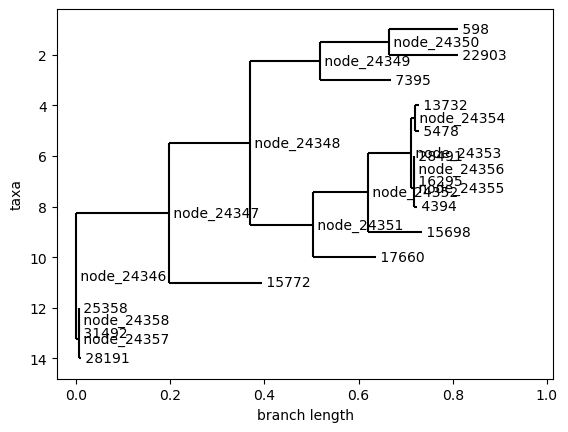

In [9]:
Phylo.draw(sub['70'])

The nodes have been named arbitrarily by number, starting from the root (node_0).  

To match the clusters to the nodes they represent, we can look at the 'anc' dictionary (common ancestor of leaves in each cluster).  

In [10]:
anc['70']

Clade(branch_length=0, name='node_24346')

We can check that the number of remaining leaves in the 'main' tree is the same as the number of clusters.

In [11]:
len(main.get_terminals())

505

#### Save trees, and cluster-node info for later use

**Note:** Subtrees are named by their cluster ID in the cluster definition. To see which node they correspond to, check the 'cluster_ancestor_mapping.csv'.

(minor note) For some reason Phylo.write rounds branch lengths, with no clear documentation on how to change. Use custom newick writer to preserve distances.

In [12]:
# save main tree
from proteinclustertools.tools.hierarchical_clustering import write_newick
import os
os.makedirs('tree_output', exist_ok=True)
write_newick(main, 'tree_output/main_tree.nwk')

# save subtrees to a folder
import os

subtree_dir='tree_output/subtrees/'
os.makedirs(subtree_dir, exist_ok=True)

for key in sub:
    write_newick(sub[key], subtree_dir+key+'.nwk')

# save cluster-ancestor mapping as a csv
anc_dict={cluster:ancestor.name for cluster, ancestor in anc.items()}
anc_df=pd.DataFrame.from_dict(anc_dict, orient='index', columns=['ancestor'])
anc_df.index.name='cluster'
anc_df.to_csv('tree_output/cluster_ancestor_mapping.csv')

## 2. Make annotation files, to visualize trees on ITOL

Annotations are applied at 2 levels, the main tree and each sub tree.  

For the main tree, where certain leaves represent clusters of collapsed subtrees, the annotations have to be aggregated.  
  
For each sub tree, where all leaves are individual data points, they can be labelled directly.

To start, load the cluster definitions, and convert the numeric IDs to IDs that match the annotation file.

In [30]:
import proteinclustertools.visuals.annotate as an

# do color annotations
clusters=pd.read_csv(clusterfile, dtype=str, index_col=None)
# generated when first sanitizing the fasta headers
header_map=pd.read_csv('../output/IPR001761_header_map.txt', dtype=str)
header_map['Entry']=header_map['header'].apply(lambda x: x.split('|')[1])

# map the Entry column to the clusters
clusters=clusters.merge(header_map[['id','Entry']], on='id', how='left')
clusters.head()

,id,cluster,Entry
0,28487,292,A0A6N3YWU5
1,2087,486,A0A942WDI7
2,10388,122,A0A924F5W7
3,29547,4,A0A1G9IQZ2
4,2763,380,A0A076JJ98


In [31]:
# set-up directory to store the annotations
itol_path='tree_output/ITOL/'
os.makedirs(itol_path, exist_ok=True)

We can then load the annotation table, and apply annotations with helper functions.

### Relabel tree with IDs

This file relabels all sequences present in the dataset, and can be dragged and dropped onto the main or sub trees. ITOL will say most of the IDs are not found on initially loading the data, but it will display the data correctly.

Make a set of new labels for the tree, to replace the numerical IDs and relabel collapsed nodes to 'clusters'.

In [32]:
leaf_labels=clusters[['id','Entry']].set_index('id')['Entry'].to_dict()
node_labels=pd.read_csv('tree_output/cluster_ancestor_mapping.csv', dtype=str)
cluster_sizes=clusters.groupby('cluster').size().to_dict()
node_labels['label']=node_labels['cluster'].apply(lambda x: 'cluster '+ x+' ('+str(cluster_sizes[x])+')')
node_labels=node_labels.set_index('ancestor')['label'].to_dict()

leaf_labels.update(node_labels)

tree_utils.ITOLLabelDataset('IDs', leaf_labels, itol_path)

### Aggregating proportions in clusters

For the main tree we can summarize the proportions of certain labels as pie or multibar charts.  
  
In this example, we will look at the 'Phylum' of each sequence and their distribution in each cluster.  

In [33]:
annot_table=pd.read_csv('../data/IPR001761_with_taxonomy.tsv', sep='\t')

phylums=an.AnnotateClusters(clusters, ['cluster'], annot_table, 'Phylum', 'Entry', 'Entry', dropna=False)
phylum_colors=an.ColorAnnot(phylums, 'tab20', top_n=20, saturation=.7, color_format='hex')

At this point, the annotations are still in terms of cluster IDs. We need to convert these to match tree_nodes.

In [34]:
phylums['cluster'].head()

,id,value,count
0,1,Actinomycetota,22
1,10,Pseudomonadota,4
2,10,Acidobacteriota,1
3,10,Chloroflexota,1
4,10,Lentisphaerota,1


In [35]:
# read in the cluster-ancestor mapping
anc_df=pd.read_csv('tree_output/cluster_ancestor_mapping.csv', dtype=str).rename(columns={'cluster':'id'})
anc_df.head()

,id,ancestor
0,1,node_31513
1,10,node_29251
2,100,node_23251
3,101,node_23235
4,102,node_23191


In [36]:
# select just the clusters that are in the tree to annotate, which excludes the singletons
tree_clusters=phylums['cluster'].copy()
tree_clusters=tree_clusters[tree_clusters['id'].isin(anc_df['id'])]
# finally, replace id with tree nodes
tree_clusters['id']=tree_clusters['id'].map(anc_df.set_index('id')['ancestor'])
tree_clusters.head()

,id,value,count
0,node_31513,Actinomycetota,22
1,node_29251,Pseudomonadota,4
2,node_29251,Acidobacteriota,1
3,node_29251,Chloroflexota,1
4,node_29251,Lentisphaerota,1


Now that dataset is prepped, make the actual annotations file.  

For proportions we can format the data as a multibar (stacked bar chart), or as pie charts. Both will show up outside the tree at the end of the leaves.  

In addition, the data can be normalized to percentages.
  
The basic gist for choosing the display format of proportion datasets is:
1. If the tree is dense, multibar is preferred. Else piecharts can show up okay.
2. Multibar without normalization will reflect the size of each collapsed cluster (different bar heights), while normalization will have nice uniform bars but cannot hint at total size.
3. Normalization has no impact on piechart visuals, only the value that is displayed. Usually, the normalized percentage is perhaps more useful, since counts in a piecharts are hard to gauge without knowing the total.   

In [37]:
# as raw counts
tree_utils.ITOLProportionDataset(tree_clusters, phylum_colors, datatype='multibar', outdir=itol_path)
tree_utils.ITOLProportionDataset(tree_clusters, phylum_colors, datatype='piechart', outdir=itol_path)

# normalized as precentages
tree_utils.ITOLProportionDataset(tree_clusters, phylum_colors, datatype='multibar', outdir=itol_path, percentage=True)
tree_utils.ITOLProportionDataset(tree_clusters, phylum_colors, datatype='piechart', outdir=itol_path, percentage=True)

While we have the color scheme, we can also make a file that can color all subtrees by their phylums as well.

In [38]:
leaf_phylums=clusters.copy()
leaf_phylums=leaf_phylums.merge(annot_table[['Entry','Phylum']], on='Entry', how='left')
leaf_phylum_dict=leaf_phylums.set_index('id')['Phylum'].to_dict()
leaf_phylums.head()

,id,cluster,Entry,Phylum
0,28487,292,A0A6N3YWU5,Pseudomonadota
1,2087,486,A0A942WDI7,Bacillota
2,10388,122,A0A924F5W7,Bacteroidota
3,29547,4,A0A1G9IQZ2,Pseudomonadota
4,2763,380,A0A076JJ98,Actinomycetota


Like the labels file, this can be dragged onto any sub tree to color the leaves. There will be an error for not finding IDs, but the colors will display correctly.

In [39]:
# borrow the color mappings from 'phylum_colors', available via the 'categories' key
tree_utils.ITOLColoredRangesDataset('Leaf Phylum', leaf_phylum_dict, phylum_colors['categories'], outdir=itol_path)

### Highlighting specific leaves
  
If you wish to see which leaves/clusters on the main tree have a particular feature, we can highlight them in ITOL with shape markers. 

In [40]:
# take sequences that are reviewed in UniProt
reviewed=an.AnnotateClusters(clusters, ['cluster'], annot_table, 'Reviewed', 'Entry', 'Entry', dropna=False)['cluster']
print(reviewed.shape)
reviewed.head()

(518, 3)


,id,value,count
0,1,unreviewed,22
1,10,unreviewed,8
2,100,unreviewed,7
3,101,unreviewed,17
4,102,unreviewed,43


In [41]:
# to label just the reviewed sequences, drop the unreviewed sequences
reviewed=reviewed[reviewed['value']=='reviewed']
print(reviewed.shape)
reviewed.head()

(13, 3)


,id,value,count
46,14,reviewed,2
55,147,reviewed,1
184,262,reviewed,1
246,317,reviewed,1
265,333,reviewed,1


In [42]:
# match the list of ids to the tree
tree_reviewed=reviewed.copy()
tree_reviewed['id']=tree_reviewed['id'].map(anc_df.set_index('id')['ancestor'])
tree_reviewed.head()

,id,value,count
46,node_28402,reviewed,2
55,node_18286,reviewed,1
184,node_15546,reviewed,1
246,node_11587,reviewed,1
265,node_8640,reviewed,1


In [43]:
# since highligting can also apply to single leaves, we also convert the ids to the leaf nodes if applicable
cluster_sizes=clusters.groupby('cluster').size()
singletons_clusters=cluster_sizes[cluster_sizes==1].index
singletons=clusters[clusters['cluster'].isin(singletons_clusters)]
singletons_dict=singletons.set_index('cluster')['id'].to_dict()

tree_reviewed['id']=tree_reviewed['id'].apply(lambda x: singletons_dict.get(x, x))

Check list of nodes to highlight. In this case, all are from collapsed nodes, and none from leaves.

In [44]:
to_highlight=tree_reviewed['id'].to_list()
print(to_highlight)

['node_28402', 'node_18286', 'node_15546', 'node_11587', 'node_8640', 'node_7957', 'node_6633', 'node_26156', 'node_5532', 'node_25854', 'node_25732', 'node_930', 'node_24662']


Make and save the annotation.  
  
Only difference is if the labels are shown on the tree directly (internal=True), or outside the tree (internal=False).  

In [45]:
tree_utils.ITOLBinaryDataset('Reviewed', to_highlight, shape=2, color='#ff0000', outdir=itol_path, internal=True)
tree_utils.ITOLBinaryDataset('Reviewed', to_highlight, shape=2, color='#ff0000', outdir=itol_path, internal=False)

Like the proportions, we can make a master file for all subtrees that highlights any reviewed sequences.

However, due to the scarcity of reviewed sequences, this file would only really be useful for subtrees where you know a reviewed sequence exists (either searching table, or from annotations of main tree).    

In [46]:
leaf_reviewed=clusters.copy()
leaf_reviewed=leaf_reviewed.merge(annot_table[['Entry','Reviewed']], on='Entry', how='left')
leaf_reviewed=leaf_reviewed[leaf_reviewed['Reviewed']=='reviewed']
leaves_to_highlight=leaf_reviewed['id'].to_list()

tree_utils.ITOLBinaryDataset('Leaf Reviewed', leaves_to_highlight, shape=2, color='#ff0000', outdir=itol_path, internal=False)

## 3. Representative selection

With a tree structure, the user can select any representative from an arbitrary node in the tree.  
  
Here we assume the user has looked at the tree and wants the representative given a 'clade' of sequences. A clade is just any internal node and all of its children, and is effectively a sequence cluster that can be defined at any depth of the tree.  

In [47]:
# read the full tree
tree=Phylo.read('../output/IPR001761_hc_tree.nwk', 'newick')
# turn the tree into a clade lookup
clades={clade.name:clade for clade in tree.get_nonterminals()}

We can make a cluster table, and use helper functions to extract representatives.

In [48]:
target_nodes=['node_24665','node_24892'] # can be as many as you want, just has to be an internal node

target_dict={}
for node in target_nodes:
    # get all leaves
    clade=clades[node]
    for leaf in clade.get_terminals():
        target_dict[leaf.name]=node
target_df=pd.DataFrame.from_dict(target_dict, orient='index', columns=['cluster'])
target_df.index.name='id'
target_df.reset_index(inplace=True)
target_df.head()

,id,cluster
0,29297,node_24665
1,4232,node_24665
2,29212,node_24665
3,21636,node_24665
4,9532,node_24665


We can use helper functions to get the best representatives of each cluster.  
  
Using the HMM approach:  

In [49]:
import proteinclustertools.tools.hmm_cluster_rep  as hmm_rep
import os

fasta_file='../output/IPR001761_cleaned.fasta'

rep_out='tree_output/target_representatives/'
os.makedirs(rep_out, exist_ok=True)

# load the header map, to convert numeric IDs back to the original headers
header_rep_map=pd.read_csv('../output/IPR001761_header_map.txt', dtype=str)
header_rep_map['header']=header_map['header'].apply(lambda x: x.split('|')[1])

hmm_rep.ParseClusterLevel(target_df, 'cluster', fasta_file, target_df['cluster'].unique(), rep_out+'example_node_reps.zip', id_map=header_rep_map)

Or the Vector approach:

In [50]:
import proteinclustertools.tools.vector_cluster_rep as vec_rep
import pickle

# load vector embeddings
vec_file='../output/IPR001761_embeddings.pkl'
embeddings=pickle.load(open(vec_file, 'rb'))
vreps=vec_rep.ClusterVectorRepresentative(target_df, 'cluster', embeddings, target_df['cluster'].unique())

In [51]:
vreps.head()

,cluster,top_hit
0,node_24665,10559
1,node_24892,7355


Collect vector representatives from the fasta file.

In [52]:
from Bio import SeqIO

id_map=header_rep_map.set_index('id')['header'].to_dict()

vec_out=rep_out+'vector_picks/'
os.makedirs(vec_out, exist_ok=True)

fasta='../output/IPR001761_cleaned.fasta'
seqs=[rec for rec in SeqIO.parse(fasta, "fasta") if rec.id in vreps['top_hit'].values]
# convert headers
for seq in seqs:
    seq.id=id_map[seq.id]
    seq.description=''

# write to file
SeqIO.write(seqs, vec_out+'top_vector_picks.fasta', "fasta")

2

In [53]:
# remap id and save csv

vreps['top_hit']=vreps['top_hit'].map(id_map)
vreps.to_csv(vec_out+'example_node_reps.csv', index=False)